# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### План выполнения проекта:
1. Загрузка и подготовка данных.

2. Обучение и провека модели для каждого региона:
  * Разбвка данных на обучающую и валидационную выборки в соотношении 75:25.
  * Обучение модели и предсказание на валидационной выборке.
  * Сохранение предсказаний и правильных ответов на валидационной выборке.
  * Вывод среднего запаса предсказанного сырья и RMSE модели.
  * Анализ результатов.

3. Подготовка к расчёту прибыли:
  * Сохранение всех ключевых значений для расчётов в отдельных переменных.
  * Рассчет достаточного объёма сырья для безубыточной разработки новой скважины. Сравнение полученного объёма сырья со средним запасом в каждом регионе. 
  * Оформление выводов по этапу подготовки расчёта прибыли.

4. Расчёт прибыли по выбранным скважинам и предсказаниям модели:
  * Выбор скважин с максимальными значениями предсказаний. 
  * Расчет целевого значение объёма сырья, соответствующее этим предсказаниям.
  * Расчет прибыли для полученного объёма сырья.

5. Определение рисков и прибыли для каждого региона:
  * Распределение прибыли с помощью техники Bootstrap с 1000 выборок.
  * Расчет средней прибыли, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
   
6. Оформление выводов и предложение региона для разработки скважин.

## Загрузка и подготовка данных

Согласно постановке задачи данные геологоразведки трёх регионов находятся в файлах: 
* `/datasets/geo_data_0.csv`. 
* `/datasets/geo_data_1.csv`. 
* `/datasets/geo_data_2.csv`. 

**Описание данных:**
* `id` — уникальный идентификатор скважины;
* `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей).

In [1]:
# импорт библиотек для выполения проекта
import pandas as pd
import numpy as np

# графика
import seaborn as sns
import matplotlib.pyplot as plt

# импортируем функции и метрики из библиотеки sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


# метрики
from sklearn.metrics import mean_squared_error


# предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
# настроим отображение чисел формата float
pd.set_option('display.float_format', '{:.4f}'.format)
# выберем общее формление для графиков
sns.set(style="white", palette="Spectral")

In [3]:
# зафиксируем псевдослучайность
RS = 2023

In [4]:
def load_data(file_name):
    ''' функция загрузки файлов '''
    try:
        folder_path = ''
        file_path = folder_path +'/'+ file_name + '.csv'
        data = pd.read_csv(file_path)
    except:
        folder_path = 'https://link/datasets'
        file_path = folder_path +'/'+ file_name + '.csv'
        data = pd.read_csv(file_path)

    return data

In [5]:
def data_info(data_name):
  '''функция выводит информацию о данных'''

  display(data_name.info())

  print('\nОписательная статистика')
  display(data_name.describe().T)

  print('\nКоличество пропусков в данных')
  display(data_name.isna().sum())

  print('\nКоличество полных дубликатов в данных')
  display(data_name.duplicated().sum())

  # визуализируем матрицу корреляции
  mask = np.triu(np.ones_like(data_name.corr(), dtype=bool));
  sns.heatmap(data_name.corr(), mask=mask,
              annot=True, 
              fmt=".3f", 
              linewidth=.5).set(title='Матрица корреляции признаков');



In [6]:
# загрузка файлов
data_0 = load_data('geo_data_0')
data_1 = load_data('geo_data_1')
data_2 = load_data('geo_data_2')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Описательная статистика


,count,mean,std,min,25%,50%,75%,max
f0,100000.0000,0.5004,0.8718,-1.4086,-0.0726,0.5024,1.0736,2.3623
f1,100000.0000,0.2501,0.5044,-0.8482,-0.2009,0.2503,0.7006,1.3438
f2,100000.0000,2.5026,3.2482,-12.0883,0.2877,2.5160,4.7151,16.0038
product,100000.0000,92.5000,44.2887,0.0000,56.4975,91.8500,128.5641,185.3643



Количество пропусков в данных


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Количество полных дубликатов в данных


0

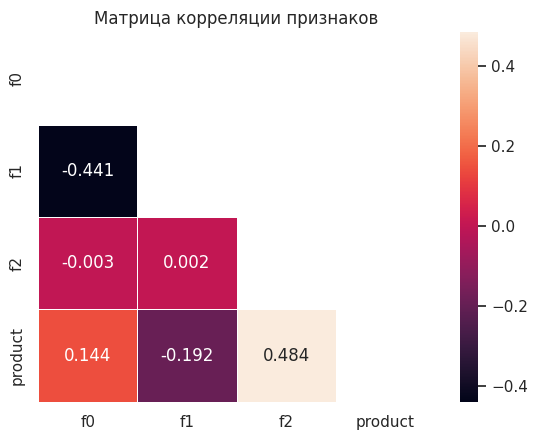

In [7]:
# выведем информацию о данных
data_info(data_0)

Первичный анализа данных показывает, что в данных по `"региону 0"`
* пропусков, и дубликатов нет;
* значение признаков `f0, f1, f2` лежат в различных числовых диапазонах;
* между признаками `f0` и `f1` имеется незначительная отлицательная линейная связь.
* между признаком `f2` и целевым признаком `product` имеется слабая линейная связь.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Описательная статистика


,count,mean,std,min,25%,50%,75%,max
f0,100000.0000,1.1413,8.9659,-31.6096,-6.2986,1.1531,8.6210,29.4218
f1,100000.0000,-4.7966,5.1199,-26.3586,-8.2680,-4.8132,-1.3328,18.7341
f2,100000.0000,2.4945,1.7036,-0.0181,1.0000,2.0115,3.9999,5.0197
product,100000.0000,68.8250,45.9444,0.0000,26.9533,57.0856,107.8130,137.9454



Количество пропусков в данных


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Количество полных дубликатов в данных


0

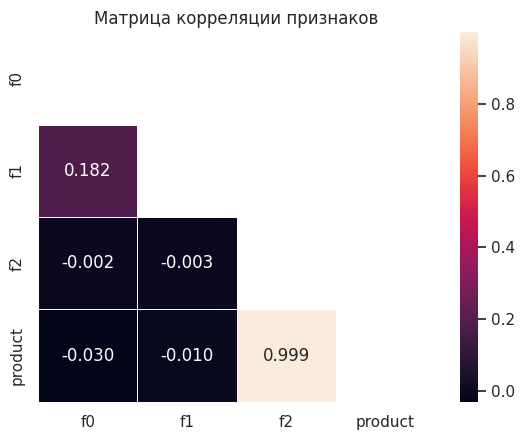

In [8]:
# выведем информацию о данных
data_info(data_1)

Первичный анализа данных показывает, что в данных по `"региону 1"`
* пропусков, и дубликатов нет;
* значение признаков `f0, f1, f2` лежат в различных числовых диапазонах;
* между признаками отсуствуют линейные связи.
* между признаком `f2` и целевым признаком `product` имеется сильная положительная линейная зависимость.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Описательная статистика


,count,mean,std,min,25%,50%,75%,max
f0,100000.0000,0.0020,1.7320,-8.7600,-1.1623,0.0094,1.1585,7.2383
f1,100000.0000,-0.0021,1.7304,-7.0840,-1.1748,-0.0095,1.1637,7.8448
f2,100000.0000,2.4951,3.4734,-11.9703,0.1304,2.4842,4.8588,16.7394
product,100000.0000,95.0000,44.7499,0.0000,59.4504,94.9256,130.5950,190.0298



Количество пропусков в данных


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Количество полных дубликатов в данных


0

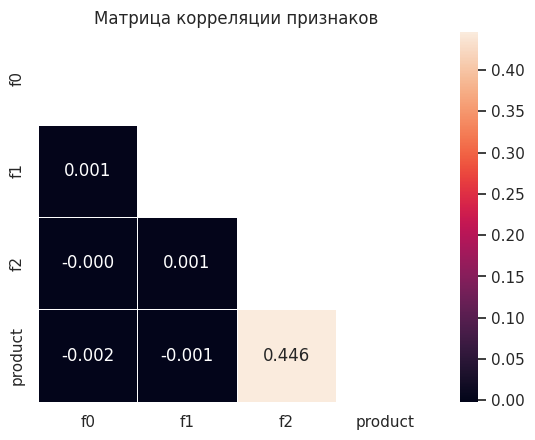

In [9]:
# выведем информацию о данных
data_info(data_2)

Первичный анализа данных показывает, что в данных по `"региону 2"`
* пропусков, и дубликатов нет;
* значение признаков `f0, f1, f2` лежат в различных числовых диапазонах;
* между признаками отсуствуют линейные связи.
* между признаком `f2` и целевым признаком `product` имеется слабая положительная линейная зависимость.

**Вывод:**
1. Загружены и проанализированы данные.
2. Пропусков и дубликатов в данных не выявлено.
3. Мультиколлениарности признаков не выявлено.
4. Признаки имеют различный диапазон, следовательно для их дальнейшего использования в линейной модели необходимо провести масштабирование.


## Обучение и проверка модели

In [10]:
def feature_train_split(df):
    '''функция подготовливает данные:
    1. выделяет фичи и таргет
    2. делит выборку на обучающую и валидационную (75:25)
    3. масштабирует числовые признаки '''
    features = df.drop(['product', 'id'],  axis=1)
    target = df['product']

    features_train, features_valid, target_train, target_valid = train_test_split(
      features, target,
      test_size=0.25,
      random_state=RS)

    # проверим размеры выборок
    print(f'Размер исходных данных: {df.shape[0]}')
    print(f'Размер обучающей выборки: {features_train.shape[0]}')
    print(f'Размер валидационной выборки: {features_valid.shape[0]}')

    # определяем числовые признаки
    numeric = ['f0', 'f1', 'f2']

    # проводим масштабирование
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])

    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])

    return features_train, target_train, features_valid, target_valid

In [11]:
def predictions(features_train, target_train, features_valid, target_valid):
    ''' функция моделирует предсказания и рассчитывает RSME'''
    # создаем модель линейной регрессии
    model = LinearRegression()
    # обучаем модель
    model.fit(features_train, target_train)
    # создаем предсказания на валиационной выборке
    predictions_valid = model.predict(features_valid)
    # рассчитываем RSME
    rsme = mean_squared_error(target_valid, predictions_valid) ** 0.5
    predictions_valid = pd.Series(predictions_valid)

    return predictions_valid, rsme

#### 1. `Регион_0`

In [13]:
# подготовим данные 
features_train_0,  target_train_0, features_valid_0, target_valid_0 = feature_train_split(data_0)

Размер исходных данных: 100000
Размер обучающей выборки: 75000
Размер валидационной выборки: 25000


In [14]:
# посмотрим что нам предсказывает модель
predictions_valid_0, rsme_0 = predictions(features_train_0,  target_train_0, features_valid_0, target_valid_0)
print(f'Cредний запас предсказанного сырья: {predictions_valid_0.mean():.4f} тыс. баррелей')
print(f'RMSE модели: {rsme_0:.4f}')

Cредний запас предсказанного сырья: 92.6514 тыс. баррелей
RMSE модели: 37.4691


#### 2. `Регион_1`

In [15]:
# подготовим данные 
features_train_1,  target_train_1, features_valid_1, target_valid_1 = feature_train_split(data_1)

Размер исходных данных: 100000
Размер обучающей выборки: 75000
Размер валидационной выборки: 25000


In [16]:
predictions_valid_1, rsme_1 = predictions(features_train_1, target_train_1,
                                          features_valid_1, target_valid_1)
print(f'Cредний запас предсказанного сырья: {predictions_valid_1.mean():.4f} тыс. баррелей')
print(f'RMSE модели: {rsme_1:.4f}')

Cредний запас предсказанного сырья: 68.7066 тыс. баррелей
RMSE модели: 0.8881


#### 3. `Регион_2`

In [17]:
# подготовим данные 
features_train_2,  target_train_2, features_valid_2, target_valid_2 = feature_train_split(data_2)

Размер исходных данных: 100000
Размер обучающей выборки: 75000
Размер валидационной выборки: 25000


In [18]:
predictions_valid_2, rsme_2 = predictions(features_train_2,  target_train_2, features_valid_2, target_valid_2)
print(f'Cредний запас предсказанного сырья: {predictions_valid_2.mean():.4f} тыс. баррелей')
print(f'RMSE модели: {rsme_2:.4f}')

Cредний запас предсказанного сырья: 95.0239 тыс. баррелей
RMSE модели: 40.1767


**Выводы:**

* Самые высокие средние запасы предсказаны моделью `LinearRegression` в `Регион_0` и `Регион_2`, но при этом и RSME большие, то говорит о то, что модели не хватает точности.
* В `Регион_1` предсказанные средние запасы нефти составляют 68,71 тыс.баррелей со средним отклонением от реальных данных на 0,89 тыс.баррелей. Это объясняется тем, что линейная модель прекрасно отработала наличие линейной зависимости между признаком `f2` и целевым показателем.

## Подготовка к расчёту прибыли

In [20]:
# ключевые значения для расчета прибыли зададим в тыс.руб.

# при разведке региона исследуют 500 точек
COUNT_WELL = 500
# 200 лучших точек для разработки
COUNT_WELL_TOP = 200
# бюджет на разработку скважин в регионе — 10 млрд рублей
BUDGET_REGION = 10_000_000
# доход с 1000 баррелей нефти составляет 450 тыс. рублей,
PRICE_1K_BARREL = 450


In [21]:
volume = BUDGET_REGION / PRICE_1K_BARREL
print(f'Минимальный объем добычи нефти в регионе для безубыточной деятельности {volume:.1f} тыс.баррелей')

min_product = volume / COUNT_WELL_TOP
print(f'Минимальный объем добычи нефти из 1 скважины {min_product:.1f} тыс.баррелей')

Минимальный объем добычи нефти в регионе для безубыточной деятельности 22222.2 тыс.баррелей
Минимальный объем добычи нефти из 1 скважины 111.1 тыс.баррелей


**Выводы:**
 * Минимальный объем нефти, добываемой из одной скважины, при условии разработки 200 месторождений в регионе составляет $111$ тыс. баррелей.
 * Ни одно из предсказанных средних значений по трем исследуемых регионов не удовлетворяет минимальному порогу добычи.
 * Необходимо выбрать максимальные по добыче точки и максимально точную модель для предсказания.

Создаем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 1. Выбор скважины с максимальными значениями предсказаний. 
 2. Суммирование целевое значение объёма сырья, соответствующее этим предсказаниям.
 3. Рассчет прибыль для полученного объёма сырья.

In [23]:
def profit(target, predictions):
    ''' функция выбирает наиболее перспективные по предсказанному объему
    добычи, и на основании имеющихся данных производит расчет прибыли от 
    разработки этих скважин в регионе'''
    predictions_sorted = predictions.sort_values(ascending=False)
    target_selected = target[predictions_sorted.index][:COUNT_WELL_TOP]
    profit = PRICE_1K_BARREL * target_selected.sum() - BUDGET_REGION
    return  profit

## Расчёт прибыли и рисков 

In [24]:
# количество выборок Bootstrap
BOOT_COUNT = 1000

In [25]:
def profit_dist(target, predictions, quantile):
    '''функция методом Bootstrap находит распределение прибыли:
    * из 500 рандомных точек отбираются 200 лучших
    * выводит средную прибыль по распределению
    * расчитывает доверительный интервал
    * расчитывает риск убытков'''

    state = np.random.RandomState(RS)
    profit_values = []
    for i in range(BOOT_COUNT):
        target_subsample = target.reset_index(drop=True).sample(n=COUNT_WELL,
                                                                          replace=True,
                                                                          random_state=state)
        predictions_selected = predictions[target_subsample.index]
        profit_values.append(profit(target_subsample, predictions_selected)/1000) # 1000 - перевод в млн.руб.

    # распределение прибыли  
    profit_values = pd.Series(profit_values)

    # вероятность убытков
    risk = len(profit_values.loc[lambda x: x < 0]) / BOOT_COUNT 

    lower = profit_values.quantile((1 - quantile)/2)
    upper = profit_values.quantile(1 - (1 - quantile)/2)

    print(f'Среднее значение прибыли для региона: {profit_values.mean():.2f} млн.руб.')
    print(f'Границы доверительного интервала: [{lower:.2f} млн.руб.; {upper:.2f} млн.руб.] ')
    print(f'Риск убытков: {risk:.2%}')

    return profit_values, lower, upper, risk


In [26]:
def profit_plotting(profit, lower, upper, region_num):
    '''визуализация полученных результатов'''

    # построим полученное распределение
    f, (ax_box, ax_hist) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (6,8))
    f.suptitle(f'Распределение прибыли для `Региона {region_num}`')
    # ящик с усами
    sns.boxplot(x=profit, ax=ax_box)
    sns.histplot(x=profit, ax=ax_hist, bins = 100, kde=True)
    # построим границы доверительного интервала
    ymin, ymax = ax_hist.get_ylim()
    ax_hist.vlines(x=[lower, upper], ymin=ymin, ymax=ymax, ls='--')

    plt.show()

#### `Регион 0`

In [27]:
# расчитаем показатели и построим графики
profit_0, lower_0, upper_0, risk_0 = profit_dist(target_valid_0, predictions_valid_0, 0.95)

Среднее значение прибыли для региона: 431.97 млн.руб.
Границы доверительного интервала: [-63.85 млн.руб.; 957.15 млн.руб.] 
Риск убытков: 4.70%


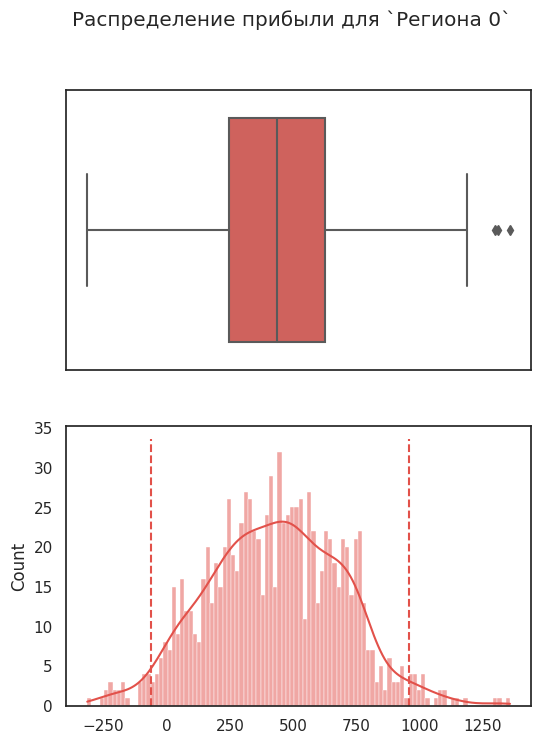

In [28]:
profit_plotting(profit_0, lower_0, upper_0, 0)

#### `Регион 1`

Среднее значение прибыли для региона: 510.79 млн.руб.
Границы доверительного интервала: [80.30 млн.руб.; 947.93 млн.руб.] 
Риск убытков: 0.80%


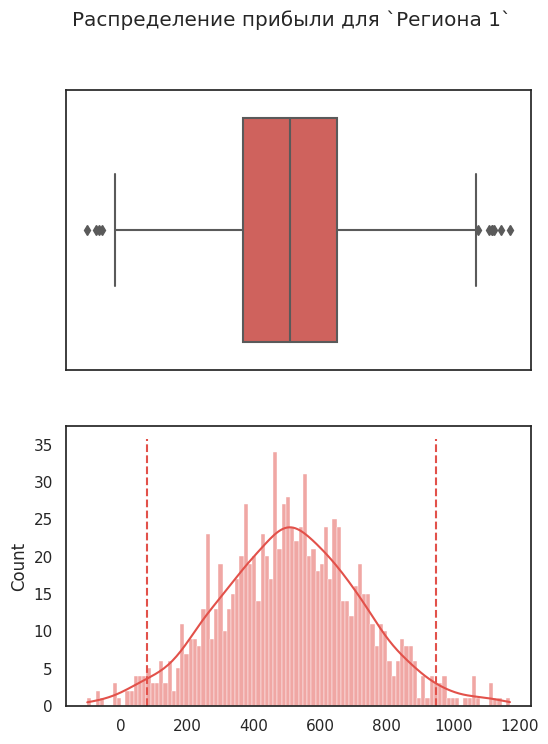

In [29]:
# расчитаем показатели и построим графики
profit_1, lower_1, upper_1, risk_1 = profit_dist(target_valid_1, predictions_valid_1, 0.95)
profit_plotting(profit_1, lower_1, upper_1, 1)

#### `Регион 2`

Среднее значение прибыли для региона: 398.23 млн.руб.
Границы доверительного интервала: [-139.87 млн.руб.; 982.33 млн.руб.] 
Риск убытков: 7.50%


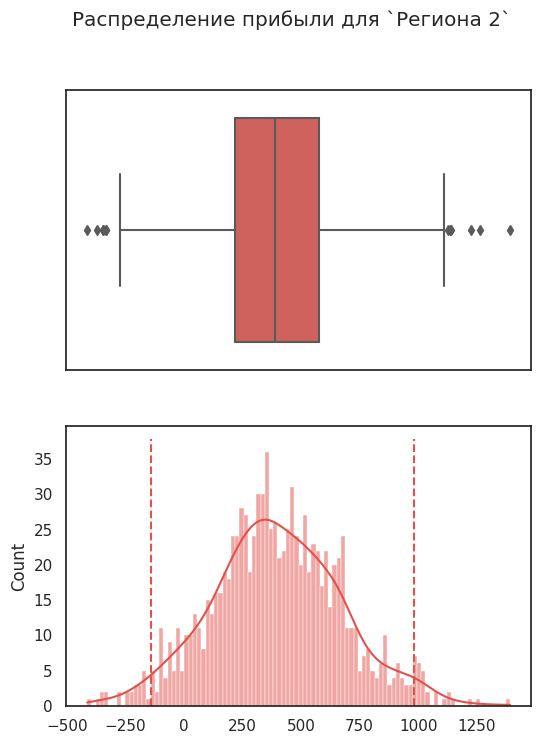

In [30]:
# расчитаем показатели и построим графики
profit_2, lower_2, upper_2, risk_2 = profit_dist(target_valid_2, predictions_valid_2, 0.95)
profit_plotting(profit_2, lower_2, upper_2, 2)

**Выводы:**
В ходе применения техники `Bootstrap` была расчитана прибыль, $95\%$ доверительный интервал и риск убытков для каждого региона
* Среднее значение прибыли `Регион 0` по 200 наиболее перспективным скважинам составила $432$ млн.руб. Риск убытков $4,7\%$, что превышает установленное пороговое значение
* Среднее значение прибыли `Регион 1` по 200 наиболее перспективным скважинам составила $510$ млн.руб. Риск убытков $0,8\%$ находится на допустимом уровне.
* Среднее значение прибыли `Регион 2` по 200 наиболее перспективным скважинам составила $398$ млн.руб. Риск убытков $7,5\%$, что превышает установленное пороговое значение

###Вывод:

В ходе реализации проекта были выполнены следующие шаги:
1. Загрузка и подготовка данных.
2. Обучение и провека модели для каждого региона:
3. Подготовка к расчёту прибыли:
4. Расчёт прибыли по выбранным скважинам и предсказаниям модели:
5. Определение рисков и прибыли для каждого региона:
6. Оформление выводов и предложение региона для разработки скважин.

В ходе загрузки и исследования данных установлено:
 * Пропуски и дубликаты отсуствуют.
 * Мультиколлениарность не выявлена.
 * Признаки имеют различный диапазон, принято решение о проведении масштабирования.

В ходе ML и предсказания объёмов запасов в скважине использовалась модель `LinearRegression`. При этом установлено,
* Самые высокие средние запасы предсказаны моделью в `Регион_0` и `Регион_2`, но при этом и `RSME` большие, то говорит о то, что модели не хватает точности.
* В `Регион_1` предсказанные средние запасы нефти составляют $68,71$ тыс.баррелей со средним отклонением от реальных данных на $0,89$ тыс.баррелей. Это объясняется тем, что линейная модель прекрасно отработала наличие линейной зависимости между признаком `f2` и целевым показателем.

В ходе подготовки к расчёту прибыли установлено, что для безубыточной деятельности по разработке скважин в регионе минимальная добыча составляет $22 222$ тыс.баррелей, а из расчета на 1 скважину это более $111$ тыс.баррелей.
Ни одно из предсказанных средних значений по трем исследуемых регионов не удовлетворяет минимальному порогу добычи на скважину, следовательно необходимо рассматривать совокупный объем добычи в регионе.

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

С учетом данного задания в ходе расчет прибыли, риска убытков в качестве региона к разработке предлагается `Регион 1`:
* средняя прибыль составляет $510$ млн.руб.;
* $95\%$ доверительный интервал - `[80.30 млн.руб.; 947.93 млн.руб.]`;
* риск убытков менее $1\%$

При этом, модель `LinearRegression` отличилась наибольшей точностью предсказания именно на данных этого региона, с точки зрения рисков, этот регион еще и поэтому является наиболее перспективным для разработки.




